## Используемые библиотеки и функции

In [4]:
import numpy as np
import datetime
import random
import pandas as pd
from scipy.stats import lognorm
import matplotlib.pyplot as plt
from itertools import product

In [5]:
def date_generator(quantity: int, start_date: str, end_date: str):
    MULTIPLIER = 10 ** 9
    start_date = pd.to_datetime(start_date).value // MULTIPLIER
    end_date = pd.to_datetime(end_date).value // MULTIPLIER
    
    return pd.to_datetime(pd.Series(np.random.randint(start_date, end_date, quantity)).astype(np.int64) * MULTIPLIER)

def random_bin_var(length_of_list):
    return np.random.randint(0, 2, length_of_list)

def get_lognorm_distr(sr, disp, length_of_list):
    mu = np.log(sr / np.sqrt(1 + (disp ** 2) / sr ** 2))
    sigma = np.sqrt(np.log(1 + (disp ** 2)/(sr ** 2)))

    return pd.Series([lognorm.rvs(s=sigma, loc=0, scale=np.exp(mu)) for i in range(0,length_of_list)])

def show_feature_importance(model):
    return pd.DataFrame([(x,y) for x, y in zip(X_train.columns.tolist(), model.coef_[0])]).sort_values(by=1, ascending=True)

## Создание базы пользователей


Имеющиеся каналы коммуникации c клиентами: "Голубиная почта", "Санта-Клаус", "ОМОН", "Сигнальные костры"

Имеющиеся продукты компании: (Плюшевые мишки, Ёлочные игрушки, Алкоголь, Бентли, Памперсы)

Список полей признаков для пользователя:
    1) Пол (0, 1) <br>
    2) Возраст (20 - 60) <br>
    3) Регион (список категорий 4) ["Шир", "Мордор", "Телепузия", "Мумидол"] <br>
    4) Частота прежних покупок (float) <br>
    5) Признак нового клиента (0, 1) <br>
    6) Дата первой покупки <br>
    6) Канал прихода клиента в кампанию (список категорий 5) ["from friends","from family", "from site", "from partner-company", "from street"] <br>
    7) Тип первого продукта клиента (список категорий 5) <br>
    8) Общая сумма трат клиента (float) <br>
    9) Общее число покупок <br>
    Число покупок каждого из 5 продуктов: <br>
        9 - 13 <br>
    Сумма трат на каждый из 5 продуктов: <br>
        13 - 18  <br>

In [6]:
%%time
## Генерация базы клиентов (100 тыс. клиентов)
CNT_CLIENTS = 100_000
START_ID = 200_000

products_list=["Плюшевые мишки", "Ёлочные игрушки", "Алкоголь", "Бентли", "Памперсы"]

client_base = \
{
    "client_id" : list(range(START_ID, START_ID + CNT_CLIENTS)),
    "is_female" : random_bin_var(CNT_CLIENTS),
    "region" : np.random.choice(["Шир", "Мордор", "Телепузия", "Мумидол"], CNT_CLIENTS),
    "buy_frequency" : get_lognorm_distr(sr=0.5, disp=1, length_of_list=CNT_CLIENTS), # в среднем одна покупка за два месяца
    "is_new_client" : random_bin_var(CNT_CLIENTS),
    "first_buy_dt" :date_generator(CNT_CLIENTS, "2015-01-01", "2020-12-31"),
    "came_from" : np.random.choice(["from friends", "from family", "from site", "from partner-company", "from street"],
                                  CNT_CLIENTS),
    "first_product": np.random.choice(["Плюшевые мишки", "Ёлочные игрушки", "Алкоголь", "Бентли", "Памперсы"],
                                  CNT_CLIENTS),
    "spent_total":get_lognorm_distr(sr=20_000, disp=40_000, length_of_list=CNT_CLIENTS),
    "buyed_items_total_cnt":get_lognorm_distr(sr=3, disp=6, length_of_list=CNT_CLIENTS),
    
}


# генерация денег для каждого продукта

spent_on_products_dict = {}

lognorm_parameters = {'Плюшевые мишки': (10_300, 20_000),
                      'Ёлочные игрушки': (3_200, 2_200),
                      'Алкоголь': (5_800, 20_000),
                      'Бентли': (3_000, 100_000),
                      'Памперсы': (3_000, 3_000)
                     }


for prod in products_list:
    spent_on_products_dict[prod] = get_lognorm_distr(sr=lognorm_parameters[prod][0],
                                                     disp=lognorm_parameters[prod][1],
                                                    length_of_list=CNT_CLIENTS)

# генерация числа покупок для каждого продукта

buyed_products_cnt_dict = {}

lognorm_parameters_by_cnt = {'Плюшевые мишки': (1, 1.5),
                      'Ёлочные игрушки': (5, 5),
                      'Алкоголь': (3, 10),
                      'Бентли': (0.1, 10),
                      'Памперсы': (3, 3)
                     }


for prod in products_list:
    buyed_products_cnt_dict[prod] = get_lognorm_distr(sr=lognorm_parameters_by_cnt[prod][0],
                                                     disp=lognorm_parameters_by_cnt[prod][1],
                                                    length_of_list=CNT_CLIENTS)

# объединение всего в один DataFrame
prod_names_in_bd = {'Плюшевые мишки': "teddy_bear",
                      'Ёлочные игрушки': "сhristmas_decorations",
                      'Алкоголь': "alco",
                      'Бентли': "bently",
                      'Памперсы': "diapers"
                     }

client_base_df = pd.DataFrame(client_base)

for prod in spent_on_products_dict:
    client_base_df.loc[:, "spent_on_"+prod_names_in_bd[prod]] = spent_on_products_dict[prod]
    
for prod in spent_on_products_dict:
    client_base_df.loc[:, "buyed_of_"+prod_names_in_bd[prod]] = buyed_products_cnt_dict[prod]

Wall time: 41.6 s


In [7]:
client_base_df.to_csv("client_base_for_new_communications.csv", index=False, encoding='cp1251', sep=';', decimal=',')

## Генерация базы коммуникаций

In [3]:
client_base_df = pd.read_csv("client_base.csv", sep=";", decimal=",", encoding="cp1251")

In [4]:
communication_channel_collection = ["Голубиная почта", "Санта-Клаус", "ОМОН", "Сигнальные костры"]
products_list = ["Плюшевые мишки", "Ёлочные игрушки", "Алкоголь", "Бентли", "Памперсы"]

contact_history = pd.DataFrame(columns=['camp_id', 'camp_start_dt', 'promoted_product', 
                                        'channel', 'client_id', 'response_flg'])

for camp_num, (channel, product_) in enumerate(product(communication_channel_collection, products_list)):
    camp_size = random.randint(1000, 10000)
    camp_start_dt = date_generator(1, "2020-01-01", "2020-12-31")[0]
    
    p_resp = (np.random.randint(7, 40) / 100 / 10 )
    
    camp_data = \
    {'camp_id':["CAMP"+str(camp_num)] * camp_size, 
         'camp_start_dt': [camp_start_dt] * camp_size,
         'promoted_product':[product_] * camp_size,
         'channel':[channel] * camp_size,
         'client_id': client_base_df.client_id.sample(camp_size).tolist(),
         'response_flg':np.random.choice([0, 1], p = [1 - p_resp, p_resp], size=camp_size)}
    contact_history = contact_history.append(pd.DataFrame(camp_data), ignore_index=True)
    # print((camp_num, channel, product_), end=" ")

In [5]:
agg_info = contact_history.groupby(['camp_id','promoted_product','channel']).agg({'client_id':'count',
                                                                                  'response_flg':'sum'})
agg_info.loc[:, 'resp_pct'] = agg_info['response_flg'] / agg_info['client_id']
agg_info

,,,client_id,response_flg,resp_pct
camp_id,promoted_product,channel,,,
CAMP0,Плюшевые мишки,Голубиная почта,8187,207,0.025284
CAMP1,Ёлочные игрушки,Голубиная почта,6389,89,0.013930
CAMP10,Плюшевые мишки,ОМОН,9417,385,0.040884
CAMP11,Ёлочные игрушки,ОМОН,8324,304,0.036521
CAMP12,Алкоголь,ОМОН,7752,188,0.024252
CAMP13,Бентли,ОМОН,3417,92,0.026924
CAMP14,Памперсы,ОМОН,9842,131,0.013310
CAMP15,Плюшевые мишки,Сигнальные костры,1118,10,0.008945
CAMP16,Ёлочные игрушки,Сигнальные костры,4837,35,0.007236


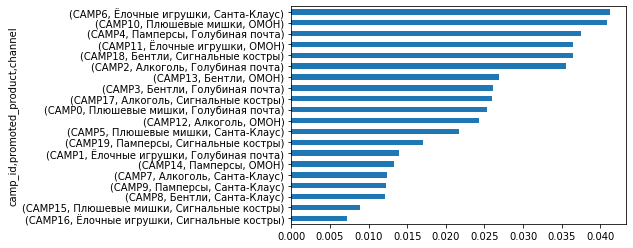

In [6]:
agg_info.resp_pct.sort_values().plot(kind='barh');

In [8]:
contact_history.to_csv("contact_history.csv",sep=";", decimal=",", encoding="cp1251", index=False)

## Обучение моделек

In [1]:
import numpy as np
import datetime
import random
import pandas as pd
from scipy.stats import lognorm
import matplotlib.pyplot as plt
from itertools import product


from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

from IPython.display import clear_output, display, HTML
import ipywidgets as widgets

In [2]:
client_base_df = pd.read_csv("client_base.csv", sep=";", decimal=",", encoding="cp1251")
contact_history = pd.read_csv("contact_history.csv", sep=";", decimal=",", encoding="cp1251")

main_train_sample = pd.merge(contact_history, client_base_df, 
                            how='inner', left_on = 'client_id',
                            right_on = 'client_id')

main_train_sample = main_train_sample.astype({"camp_start_dt":'datetime64[ns]', "first_buy_dt":'datetime64[ns]'})

In [3]:
# обучение моделей
sample_ids = ['promoted_product', 'channel']
target = ['response_flg']
train_fields = ['camp_start_dt','is_female', 'region', 'buy_frequency', 'is_new_client',
                   'first_buy_dt', 'came_from', 'first_product', 'spent_total',
                   'buyed_items_total_cnt', 'spent_on_teddy_bear',
                   'spent_on_сhristmas_decorations', 'spent_on_alco', 'spent_on_bently',
                   'spent_on_diapers', 'buyed_of_teddy_bear',
                   'buyed_of_сhristmas_decorations', 'buyed_of_alco', 'buyed_of_bently',
                   'buyed_of_diapers']

class Model():
    """обёртка для модели включающая предобработчик входных данных"""
    def __init__(self, model):
        self.model = model
    
    def fit(self, X, y):
        transformed = self.transform(X)
        self.model.fit(transformed, y)
        
    def predict(self, X):
        transformed = self.transform(X)
        return self.model.predict(transformed)
    
    def predict_proba(self, X):
        transformed = self.transform(X)
        return self.model.predict_proba(transformed)
    
    def transform(self, df, y=None):
        X = df.copy()
        self.multiple_choice_options = {key:X[key].unique().tolist() for key in ["region", "came_from", "first_product"]}
        
        X.loc[:, 'client_lifetime'] = (X['camp_start_dt'] - X['first_buy_dt']).dt.days
        X = pd.concat((X, pd.get_dummies(X.region, prefix='region').drop(columns="region" + "_" + "Мордор")), axis=1)
        X = pd.concat((X, pd.get_dummies(X.came_from, prefix='came_from',
                                        ).drop(columns="came_from" + "_" + "from street")), axis=1)
        X = pd.concat((X, pd.get_dummies(X.first_product, prefix='first_product')\
                       .drop(columns='first_product' + "_" + 'Алкоголь')), axis=1)


        X = X.drop(columns=['camp_id', 'promoted_product', 'channel', 'client_id' , 'region', 'first_buy_dt', 
                            'camp_start_dt', 'came_from', 'first_product', 'response_flg'])
        return X

product_x_channel_unique = main_train_sample[sample_ids].drop_duplicates().reset_index(drop=True).values

model_collection = {}

for prod, channel in product_x_channel_unique:
    X = main_train_sample.loc[(main_train_sample.promoted_product == prod) & 
                          (main_train_sample.channel == channel)].copy()
    y = main_train_sample.loc[(main_train_sample.promoted_product == prod) & 
                          (main_train_sample.channel == channel)].copy().response_flg.astype(int)
    
    model = Model(LogisticRegression(max_iter=10_000)) ## логистическая регрессия
    model.fit(X, y)
    model_collection[(prod, channel)] = model
    print("Model for product = {:<15}, channel = {:<17} is fitted".format(prod, channel), 
          datetime.datetime.now().strftime("%H-%M-%S.%f"))
    

Model for product = Плюшевые мишки , channel = Голубиная почта   is fitted 20-57-09.203813
Model for product = Бентли         , channel = Голубиная почта   is fitted 20-57-11.165570
Model for product = Бентли         , channel = ОМОН              is fitted 20-57-11.414904
Model for product = Памперсы       , channel = ОМОН              is fitted 20-57-11.691163
Model for product = Плюшевые мишки , channel = ОМОН              is fitted 20-57-11.824806
Model for product = Ёлочные игрушки, channel = ОМОН              is fitted 20-57-11.952466
Model for product = Бентли         , channel = Санта-Клаус       is fitted 20-57-12.866023
Model for product = Памперсы       , channel = Голубиная почта   is fitted 20-57-12.993682
Model for product = Ёлочные игрушки, channel = Голубиная почта   is fitted 20-57-13.080451
Model for product = Алкоголь       , channel = Голубиная почта   is fitted 20-57-13.203123
Model for product = Алкоголь       , channel = Санта-Клаус       is fitted 20-57-13.308840

## Виджеты для просмотра по одному клиенту

In [31]:
# конструирование виджетов
class Widget_constructors:
    decipher = \
            {'spent_total':"Потратил всего",
            'spent_on_alco': "Потратил на алкоголь",
             'spent_on_diapers':"Потратил на подгузники",
            'buyed_items_total_cnt':'Купил вещей всего'}
    @classmethod
    def init_widget_params(cls, df, multiple_choice_options=None):
        cls.multiple_choice_options = multiple_choice_options
        standard_buyed_cnt_param = lambda field_name: dict(description=field_name, 
                                                                  value=1, 
                                                                  min=0, 
                                                                  max=200,
                                                                  step=1)

        standard_spent_sum_param = lambda field_name:dict(value=22000,
                                                             min=0,
                                                             max=100000.0,
                                                             step=500,
                                                             description=field_name,
                                                             disabled=False,
                                                             continuous_update=False,
                                                             orientation='horizontal',
                                                             readout=True,
                                                             readout_format='.1f',
                                                        )
        standard_checkbox_param = lambda field_name:dict(value=False,
                                                             description=field_name,
                                                             disabled=False,
                                                             indent=False)

        standard_dropdown_param = lambda field_name: dict(options=['Test 1', 'Test 2', 'Test 3'],
                                value='Test 2',
                                description=field_name,
                                disabled=False,)

        field_params = {}
        for col_name in df.columns.tolist():
            check_func = lambda x, col_name: x == col_name[:len(x)]
            if check_func("spent_on", col_name):
                field_params[col_name] = standard_spent_sum_param(col_name)
            elif check_func("buyed_of", col_name):
                field_params[col_name] = standard_buyed_cnt_param(col_name)
            elif col_name in ["spent_total"]:
                field_params[col_name] = standard_spent_sum_param(col_name)
            elif col_name in ["is_female", "is_new_client"]:
                field_params[col_name] = standard_checkbox_param(col_name)
        
        for col_name in multiple_choice_options:
                field_params[col_name] = standard_dropdown_param(col_name)

        cls.field_params = field_params
    
    @classmethod
    def scroller_constructor(cls, field_name, **kwargs):
        default_args = cls.field_params[field_name].copy()
        if 'description' in kwargs:
            kwargs['description'] = cls.decipher[kwargs['description']]

        if kwargs:
            default_args.update(kwargs)

        default_args.update({'style' : {'description_width': 'initial'}})
        return widgets.FloatSlider(
                    **default_args
                        )
    
    @classmethod
    def checkbox_constructor(cls, field_name, **kwargs):
        default_dict = cls.field_params[field_name].copy()
        if kwargs:
            default_dict.update(kwargs)
        return widgets.Checkbox(**default_dict)
    
    @classmethod
    def dropdown_constructor(cls, field_name, **kwargs):
        default_dict = cls.field_params[field_name]
        default_dict.update(dict(options = cls.multiple_choice_options[field_name], 
                                 value = cls.multiple_choice_options[field_name][0]))
        if kwargs:
            default_dict.update(kwargs)
        return widgets.Dropdown(**default_dict)
    
class Handler:
    def __init__(self, for_feature, function_value_processor=None,
                df=None, model=None):
        self.for_feature = for_feature
        if df is None:
            raise
            # self.df = show_df
        else:
            self.df = df
        if model is None:
            raise
        else:
            self.model = model
        self.function_value_processor=function_value_processor
        
        
        # словари для категориальных признаков
        self.fields_dict = self.model.multiple_choice_options
        
    def _show(self):
        with result_output:
            clear_output(wait=True)
            display(HTML("""<h2 style="color:green"> Отклик: """ +\
                         str(round(self.model.model.predict_proba(self.df)[0, 1] * 100, 3)) + "% </h2>"))

    def show_model_result(self, scrl):
        """для скроллера"""
        if self.function_value_processor:
            new_value = self.function_value_processor(scrl)
        else:
            new_value = scrl['new']
        
        self.df.loc[0, self.for_feature] = new_value
        self._show()
            
    def change_categ(self, dd):
        """для dropdown"""
        
        if dd['type'] == 'change' and dd['name'] == 'value':
            categ_name = dd['new']
            
            # сначала найдём по имени категории исходное поле
            for key, value_lst in self.fields_dict.items():
                if categ_name in value_lst:
                    initial_field = key
                    break
            else:
                raise Exception("Initial field is not found")
            
            categ_field_name = initial_field + "_" + categ_name
            list_of_other_options = [initial_field + "_" + value for value in self.fields_dict[initial_field] if \
                                    value != categ_name]
            

            if categ_field_name in self.df:
                self.df.loc[:, categ_field_name] = 1
                
            for field in list_of_other_options:
                if field in self.df:
                    self.df.loc[:, field] = 0
                else:
                    pass
                    #print("warning: {} is not in self.df".format(field))
                
        self._show()
    



def return_widgets(model, show_df):
    Widget_constructors.init_widget_params(df=show_df, multiple_choice_options=model.multiple_choice_options)
    my_widgets = {}

    for col in ['spent_on_teddy_bear',
                'spent_on_сhristmas_decorations',
                'spent_on_alco',
                'spent_on_bently',
                'spent_on_diapers',
                'buyed_of_teddy_bear',
                'buyed_of_сhristmas_decorations',
                'buyed_of_alco',
                'buyed_of_bently',
                'buyed_of_diapers',
                'spent_total']:

        my_widgets[col] = Widget_constructors.scroller_constructor(col)
        my_widgets[col].observe(Handler(col, df=show_df, 
                                       model=model).show_model_result, 'value')
        setattr(my_widgets[col], 'layout', widgets.Layout(width="600px")) 
    
    
    for col in ["is_female", "is_new_client"]:
        my_widgets[col] = Widget_constructors.checkbox_constructor(col)
        my_widgets[col].observe(Handler(col, lambda x: int(x['owner'].value),
                                       df=show_df, model=model).show_model_result, 'value')    

    for col in Widget_constructors.multiple_choice_options:
        my_widgets[col] = Widget_constructors.dropdown_constructor(col)
        my_widgets[col].observe(Handler(col, df=show_df, model=model).change_categ)
    return my_widgets



def get_widgets(model):
    show_df = pd.DataFrame(model.transform(X).mean()).T
    
    my_widgets = return_widgets(model, show_df)
    return my_widgets

In [34]:
output = widgets.Output()
result_output = widgets.Output()


# check = widgets.Button(description="main button")
choose_product_widget = widgets.Dropdown(options=list(set([i[0] for i in list(model_collection.keys())])),
                 value=list(set([i[0] for i in list(model_collection.keys())]))[0],
                 description="Какой продукт продвигать:",
                 layout=widgets.Layout(width="50%"), style={"description_width":"50%"})

choose_channel_widget = widgets.Dropdown(options=list(set([i[1] for i in list(model_collection.keys())])),
                 value=list(set([i[1] for i in list(model_collection.keys())]))[0],
                 description="Через какой канал:",
                 layout=widgets.Layout(width="50%"), style={"description_width":"50%"})

@choose_product_widget.observe
def some_func(w):
    if w['type'] == 'change' and w['name'] == 'value':
        # model = np.random.choice(list(model_collection.values()))
        by_product = w['new']
        by_channel = choose_channel_widget.value
        model = model_collection[(by_product, by_channel)]
        get_widgets(model, output)

@choose_channel_widget.observe
def some_func(w):
    if w['type'] == 'change' and w['name'] == 'value':
        by_product = choose_product_widget.value
        by_channel = w['new']
        model = model_collection[(by_product, by_channel)]
        my_widgets = get_widgets(model)
        
        with output:
            clear_output(wait=True)
            display(widgets.HBox([widgets.VBox(list(my_widgets.values())), result_output]))
        my_widgets['spent_total'].value = 23000
    
display(widgets.VBox([choose_product_widget, choose_channel_widget, output]))
choose_channel_widget.value = 'Санта-Клаус'